# 임포트

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

# 데이터 로드

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/DACON_제주/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON_제주/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/DACON_제주/data/sample_submission.csv')

# EDA

```
supply(kg):
평균 공급량은 약 11,894.53kg이며,
표준편차는 상당히 크게 나타나는 52,264kg입니다.
이는 공급량에 상당한 변동이 있음을 의미합니다.
최소값은 0kg이고,
최대값은 약 1,222,800kg입니다.

price(원/kg):
평균 가격은 약 1,131.68원/kg이며,
표준편차도 2,029.94원/kg으로 매우 높습니다.
 이는 가격에도 큰 변동성이 있음을 나타냅니다.
 최소 가격은 0원/kg이며,
 최대 가격은 20,909원/kg입니다.
```

## 값이 0인 데이터

```
공급량이 0인 데이터는 총 35,452개이고,
가격이 0인 데이터도 35,455개로 확인됩니다.
이는 데이터셋에 상당수의 거래가 없는 날짜가 포함되어 있음을 의미합니다.
이러한 데이터는 가격 예측에 영향을 줄 수 있으므로,
모델을 학습하기 전에 적절한 전처리가 필요합니다.
```

In [ ]:
(train['supply(kg)'] == 0).sum(), (train['price(원/kg)'] == 0).sum()

(35452, 35455)

```
지역별 0값의 영향은 없다고 봐도 무방할듯.
TG(귤)의 0값이 압도적으로 적으며, 나머지는 비슷하다.
```

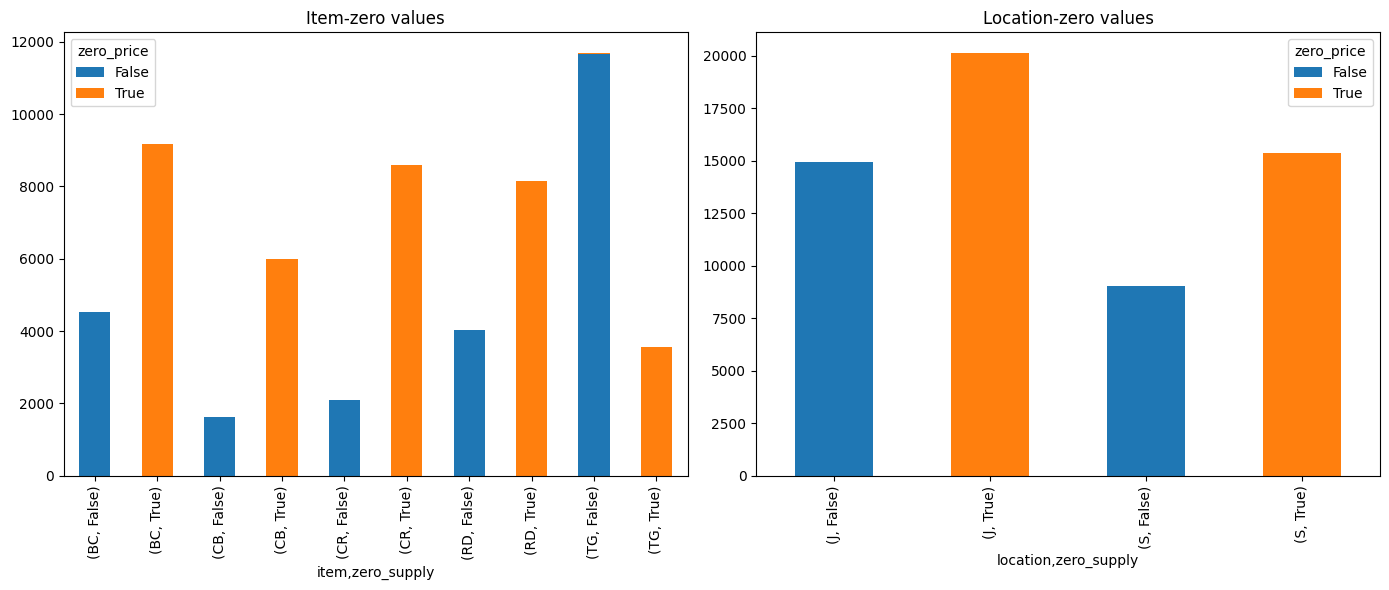

(zero_price        False  True 
 item zero_supply              
 BC   False         4525      0
      True             0   9182
 CB   False         1620      1
      True             0   5994
 CR   False         2082      0
      True             0   8579
 RD   False         4040      0
      True             0   8144
 TG   False        11675      2
      True             0   3553,
 zero_price            False  True 
 location zero_supply              
 J        False        14927      3
          True             0  20099
 S        False         9015      0
          True             0  15353)

In [ ]:
# 'timestamp'datetime형으로 변환
train['timestamp'] = pd.to_datetime(train['timestamp'])

# supply or price is zero인 피처 생성
train['zero_supply'] = train['supply(kg)'] == 0
train['zero_price'] = train['price(원/kg)'] == 0

# Group by 'item' and 'location' to see the distribution of zero values
# True : 0
zero_distribution_by_item = train.groupby(['item', 'zero_supply', 'zero_price']).size().unstack(fill_value=0)
zero_distribution_by_location = train.groupby(['location', 'zero_supply', 'zero_price']).size().unstack(fill_value=0)

# Plotting the distribution of zero values by item and location
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
zero_distribution_by_item.plot(kind='bar', stacked=True, ax=ax[0], title='Item-zero values')
zero_distribution_by_location.plot(kind='bar', stacked=True, ax=ax[1], title='Location-zero values')
plt.tight_layout()
plt.show()

zero_distribution_by_item, zero_distribution_by_location

```
대부분의 월에서 공급량과 가격이 0인 날짜들이 일정하게 나타나고 있습니다.
특히, 각 연도의 시작인 1월에 0값이 많은 것을 볼 수 있습니다.
이는 계절적 영향이나 특정 시기에 수확이 없는 것과 관련될 수 있습니다.
```

<Figure size 1500x600 with 0 Axes>

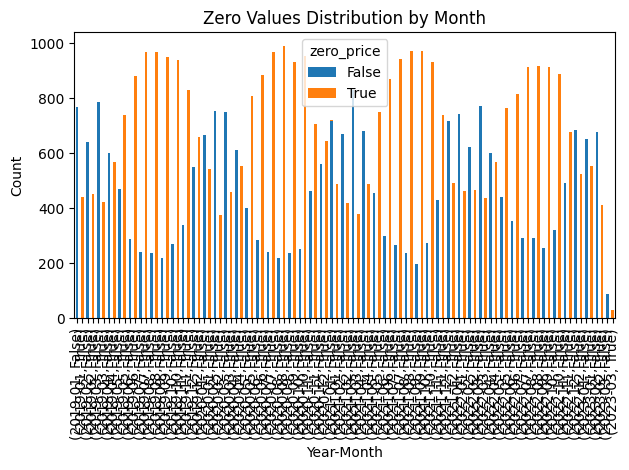

zero_price              False  True 
year_month zero_supply              
2019-01    False          769      0
           True             0    440
2019-02    False          641      0
           True             0    451
2019-03    False          787      0
...                       ...    ...
2023-01    True             0    555
2023-02    False          679      0
           True             0    413
2023-03    False           88      0
           True             0     29

[102 rows x 2 columns]

In [ ]:
# year_month 변수 생성
train['year_month'] = train['timestamp'].dt.to_period('M')
zero_distribution_by_month = train.groupby(['year_month', 'zero_supply', 'zero_price']).size().unstack(fill_value=0)

# 월별 0값의 분포
plt.figure(figsize=(15, 6))
zero_distribution_by_month.plot(kind='bar', stacked=True, title='Zero Values Distribution by Month')
plt.ylabel('Count')
plt.xlabel('Year-Month')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

zero_distribution_by_month


In [ ]:
# 'year', 'month', 'day', 'weekday' 피처를 추가
train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['day'] = train['timestamp'].dt.day
train['weekday'] = train['timestamp'].dt.weekday

# 계절 피처를 추가하는 함수를 정의
def get_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

# 계절 피처를 추가
train['season'] = train['month'].apply(get_season)

train.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),zero_supply,zero_price,year_month,year,month,day,weekday,season
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,True,True,2019-01,2019,1,1,1,4
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,True,True,2019-01,2019,1,2,2,4
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,False,False,2019-01,2019,1,3,3,4
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,False,False,2019-01,2019,1,4,4,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,False,False,2019-01,2019,1,5,5,4


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


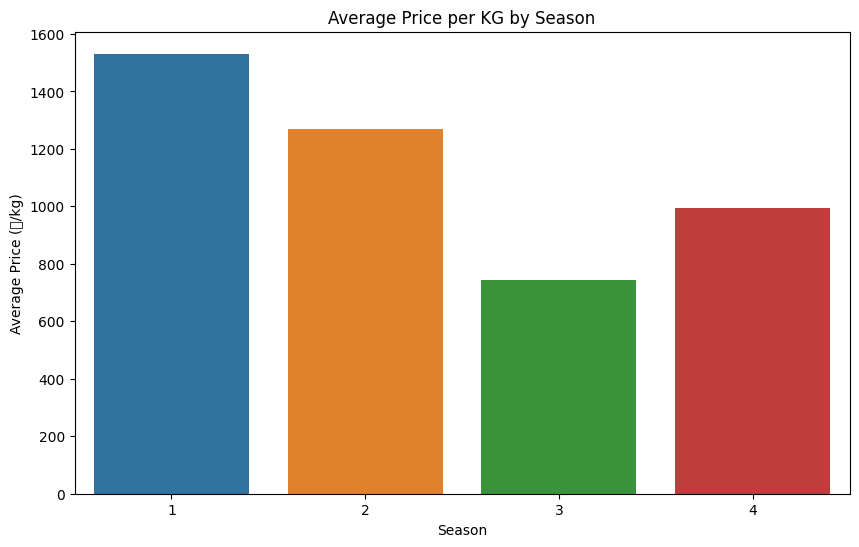

In [ ]:
# 계절별 가격의 평균 계산
seasonal_price_means = train.groupby('season')['price(원/kg)'].mean().reset_index()

# 계절별 평균 가격 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='price(원/kg)', data=seasonal_price_means, order=[1,2,3,4])
plt.title('Average Price per KG by Season')
plt.xlabel('Season')
plt.ylabel('Average Price (원/kg)')

plt.show()

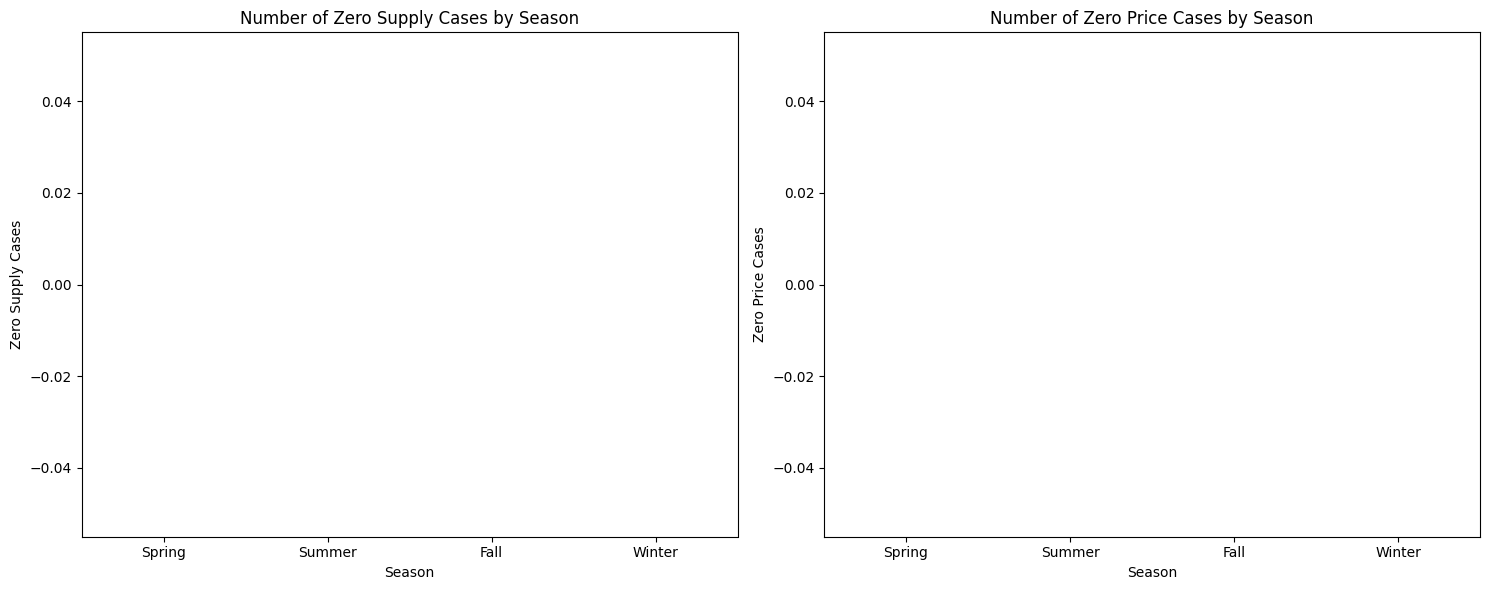

In [ ]:
# 계절별로 공급량이 0인 경우와 가격이 0인 경우의 수를 계산
seasonal_zero_supply = train.groupby('season')['zero_supply'].sum().reset_index()
seasonal_zero_price = train.groupby('season')['zero_price'].sum().reset_index()

# 계절별 공급량이 0인 경우와 가격이 0인 경우를 시각화
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x='season', y='zero_supply', data=seasonal_zero_supply, ax=ax[0], order=['Spring', 'Summer', 'Fall', 'Winter'])
ax[0].set_title('Number of Zero Supply Cases by Season')
ax[0].set_xlabel('Season')
ax[0].set_ylabel('Zero Supply Cases')

sns.barplot(x='season', y='zero_price', data=seasonal_zero_price, ax=ax[1], order=['Spring', 'Summer', 'Fall', 'Winter'])
ax[1].set_title('Number of Zero Price Cases by Season')
ax[1].set_xlabel('Season')
ax[1].set_ylabel('Zero Price Cases')

plt.tight_layout()

plt.show()

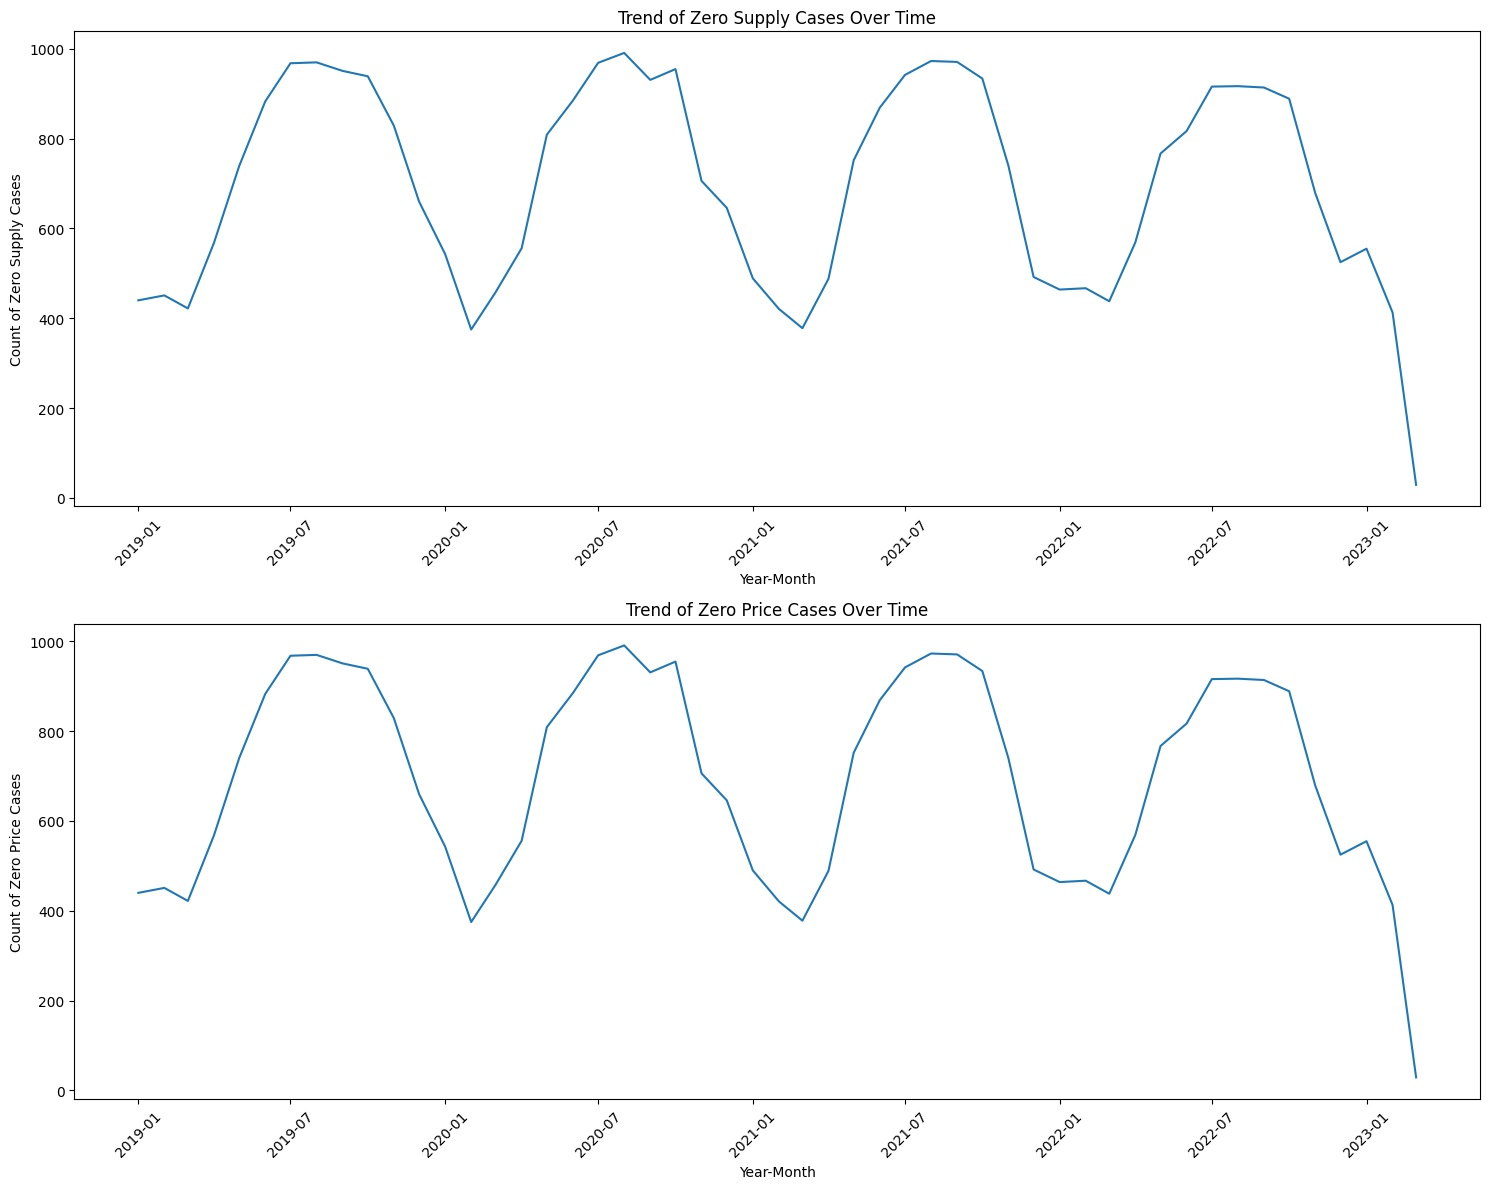

In [ ]:
# 'year_month' 컬럼이 문자열로 되어 있는지 확인합니다.
train['year_month'] = train['year_month'].astype(str)

# 문자열로 변환된 'year_month' 컬럼을 다시 datetime 형식으로 변환합니다.
train['year_month'] = pd.to_datetime(train['year_month'], format='%Y-%m')

# 다시 연도별 및 월별 공급량과 가격이 0인 경우의 추세를 확인합니다.
trend_zero_supply = train.groupby('year_month')['zero_supply'].sum().reset_index()
trend_zero_price = train.groupby('year_month')['zero_price'].sum().reset_index()

# 추세를 시각화합니다.
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

sns.lineplot(x='year_month', y='zero_supply', data=trend_zero_supply, ax=ax[0])
ax[0].set_title('Trend of Zero Supply Cases Over Time')
ax[0].set_xlabel('Year-Month')
ax[0].set_ylabel('Count of Zero Supply Cases')
ax[0].tick_params(axis='x', rotation=45)

sns.lineplot(x='year_month', y='zero_price', data=trend_zero_price, ax=ax[1])
ax[1].set_title('Trend of Zero Price Cases Over Time')
ax[1].set_xlabel('Year-Month')
ax[1].set_ylabel('Count of Zero Price Cases')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 이상치 제거
  - price
  - supply

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


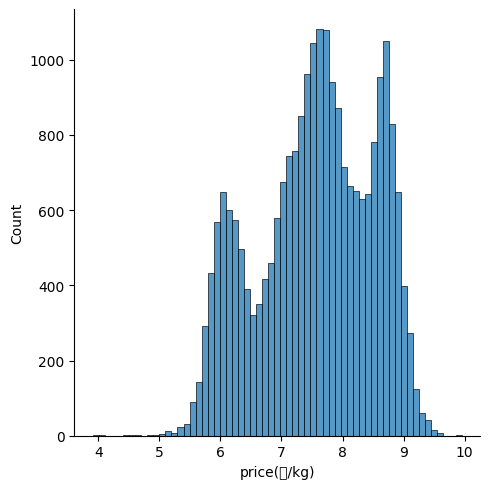

In [ ]:
sns.displot(np.log(train['price(원/kg)']))

In [ ]:
# 이상치 식별과 제거
Q1 = train['price(원/kg)'].quantile(0.25)  # 1사분위수
Q3 = train['price(원/kg)'].quantile(0.75)  # 3사분위수
IQR = Q3 - Q1

# 이상치 경계 계산
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
train = train[(train['price(원/kg)'] >= lower_bound) & (train['price(원/kg)'] <= upper_bound)]

# 이상치가 제거된 데이터프레임 확인
train.head()


,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),zero_supply,zero_price,year_month,year,month,day,weekday,season
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,True,True,2019-01-01,2019,1,1,1,4
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,True,True,2019-01-01,2019,1,2,2,4
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,False,False,2019-01-01,2019,1,3,3,4
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,False,False,2019-01-01,2019,1,4,4,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,False,False,2019-01-01,2019,1,5,5,4


In [ ]:
# 이상치 식별과 제거
Q1 = train['supply(kg)'].quantile(0.25)  # 1사분위수
Q3 = train['supply(kg)'].quantile(0.75)  # 3사분위수
IQR = Q3 - Q1

# 이상치 경계 계산
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
train = train[(train['supply(kg)'] >= lower_bound) & (train['supply(kg)'] <= upper_bound)]

# 이상치가 제거된 데이터프레임 확인
train.head()


,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),zero_supply,zero_price,year_month,year,month,day,weekday,season
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,True,True,2019-01-01,2019,1,1,1,4
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,True,True,2019-01-01,2019,1,2,2,4
5,TG_A_J_20190106,2019-01-06,TG,A,J,0.0,0.0,True,True,2019-01-01,2019,1,6,6,4
12,TG_A_J_20190113,2019-01-13,TG,A,J,0.0,0.0,True,True,2019-01-01,2019,1,13,6,4
16,TG_A_J_20190117,2019-01-17,TG,A,J,3956.0,2919.0,False,False,2019-01-01,2019,1,17,3,4


## 피처 제거
  - train
    - supply(kg), ID, timestamp, weekday_6, day
  - test
    - ID, timestamp

In [ ]:
train.drop(columns=['ID', 'timestamp', 'supply(kg)'],  axis = 1, inplace = True)
test.drop(columns=['ID', 'timestamp'],  axis = 1, inplace = True)

## 원핫 인코딩